In [1]:
import boule as bl
import ensaio
import numpy as np
import pandas as pd
import pygmt
import verde as vd
import xarray as xr
import harmonica as hm
import scipy as scipy

# Load Moho & LAB and NearestNDInterpolator Function

In [2]:
# Moho                     
moho_file_path = 'moho_depth.csv'
moho_df = pd.read_csv(moho_file_path)

camlab_file_path = "D:\\Amitava\\Projects\\Perple_X\\V2RhoT_gibbs\\LAB_geoid_data\\CAM2022_lithosphere.xyz"
camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_15088\3075723807.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])


In [3]:
moho_func = scipy.interpolate.NearestNDInterpolator(list(zip(moho_df['Latitude'], moho_df['Longitude'])), moho_df['Moho'])
camlab_func = scipy.interpolate.NearestNDInterpolator(list(zip(camlab_df['Latitude'], camlab_df['Longitude'])), camlab_df['Depth'])
#topo_func = scipy.interpolate.NearestNDInterpolator(list(zip(topo_df['latitude'], topo_df['longitude'])), topo_df['topography'])
#tta_func = scipy.interpolate.NearestNDInterpolator(list(zip(tta_df['Latitude'], tta_df['Longitude'])), tta_df['TTA'])
#geoid_func = scipy.interpolate.NearestNDInterpolator(list(zip(geoid_df['Latitude'], geoid_df['Longitude'])), geoid_df['UMG3'])

# Load Topo, Get Moho and LAB depth

In [4]:
#region = (west, east, south, north)
#region = (-78, -53, -57, -20) # SA
#region = (112, 155, -45, -10)  # Australia
#region = (68, 98, 6, 38)  # India
region = (-179.9, 179.9, -89.9, 89.9) # World

In [5]:
fname = ensaio.fetch_earth_topography(version=1)
topo = xr.load_dataarray(fname)

topo = topo.sel(latitude=slice(*region[2:]), longitude=slice(*region[:2]))
topo = topo.coarsen(latitude=2, longitude=2, boundary="trim").mean()  ## Group every 2 consecutive lat,long grid cells into one

ellipsoid = bl.WGS84

longitude, latitude = np.meshgrid(topo.longitude, topo.latitude)
reference = ellipsoid.geocentric_radius(latitude)
surface = topo + reference
sediments_depth =  xr.where(topo > 0, 2000.0, 500.0) # in m
moho_depth = moho_func(latitude, longitude)   # in Km
moho_depth = moho_depth * 1e3                 # in m
lab_depth = camlab_func(latitude, longitude)  # in Km
lab_depth = lab_depth * 1e3                   # in m


# Layer of tesseroids


In [11]:
1040.0 - 1700.0

-660.0

In [12]:
1700.0 - 2670.0

-970.0

In [8]:
3270.0 - 2850.0

420.0

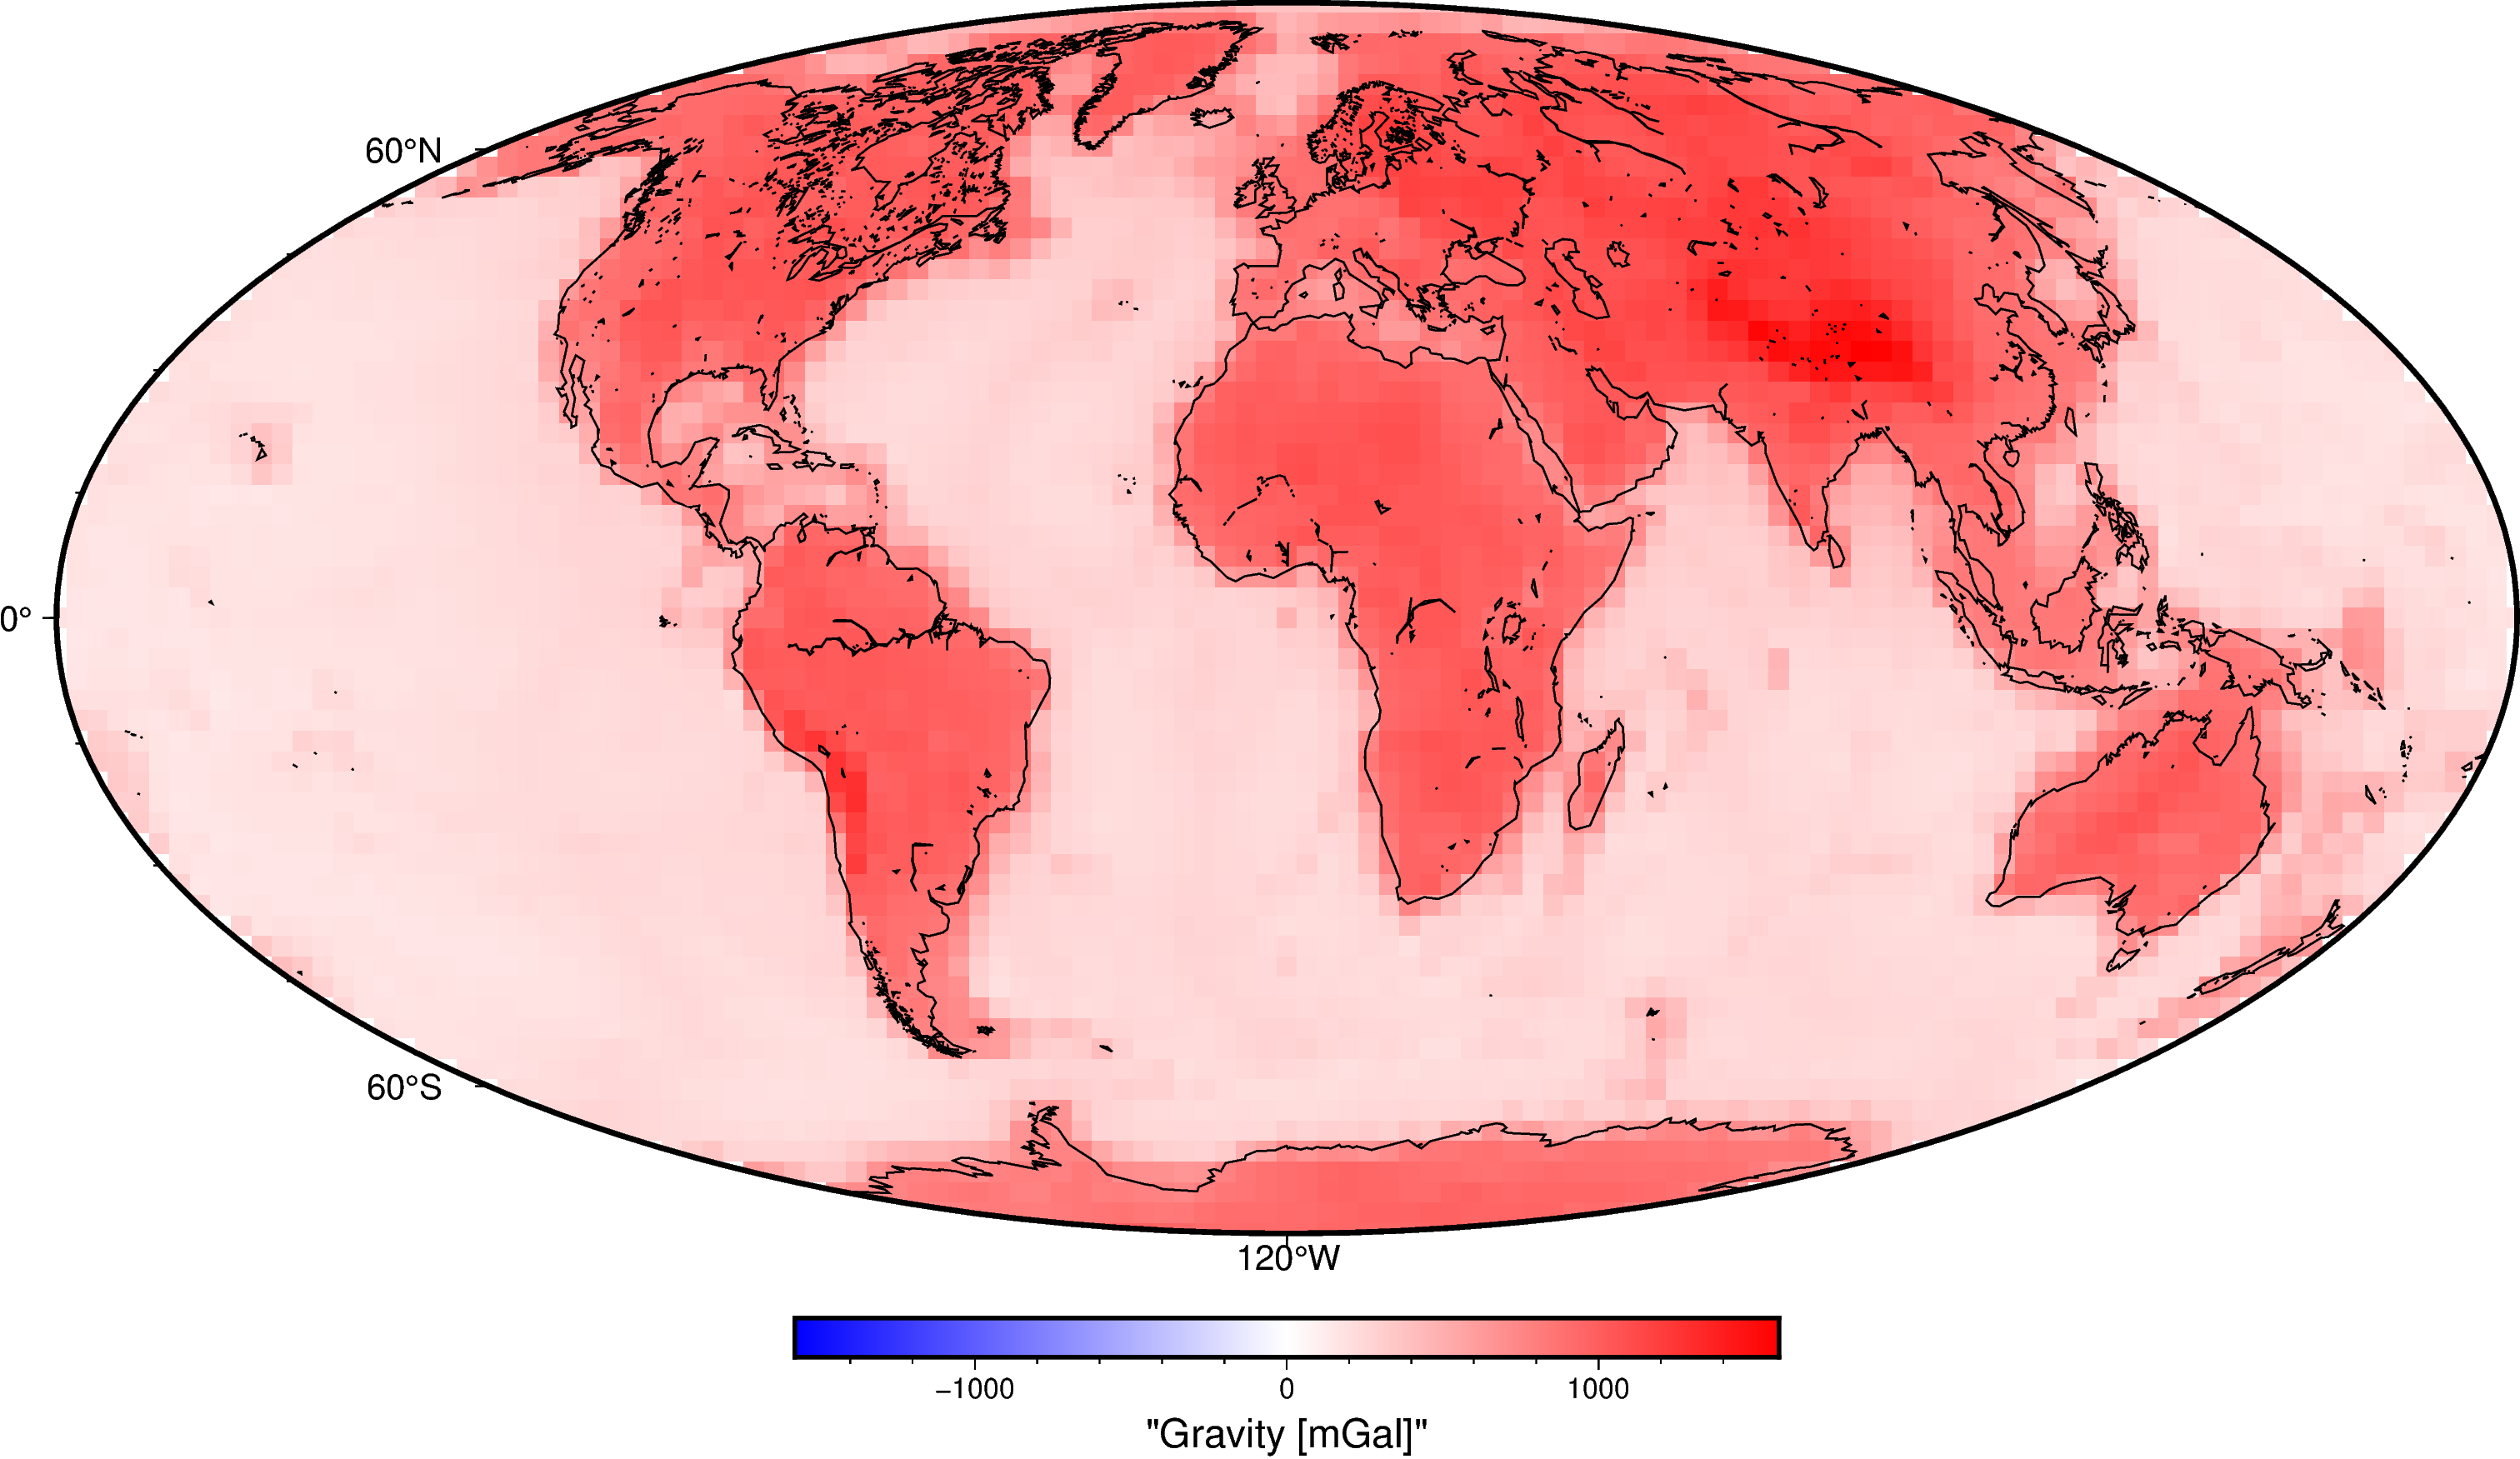

CPU times: total: 57min 23s
Wall time: 6min 16s


In [13]:
%%time
# The true surface (land or seafloor): radius from Earth's center
surface = topo + reference

# Density contrasts # kg/m³
#rho_water = 1040.0 - 3270.0     ## negative contrast removes mass   
#rho_crust = 3270.0 - 2670.0     ## positive contrast adds mass
#rho_mantle = 0.0                ## Reference, Density of mantle is 3270.0, so no density contrast
# Density contrasts # kg/m³
rho_water = 1040.0 - 2670.0  ## water contrast  
rho_sed = 2670.0 - 1300.0    ## sediments contrast    
rho_crust = 3270.0 - 2850.0  ## crust contrast 
rho_mantle = 0.0             ## Reference, Density of mantle is 3270.0, so no density contrast

# Water Layer (only where topo < 0)
water_top = reference
water_bottom = xr.where(topo < 0, reference + topo, np.nan)
water_density = xr.where(topo < 0, rho_water, np.nan)
tess_water = hm.tesseroid_layer(coordinates=(topo.longitude, topo.latitude),surface=water_top,reference=water_bottom,properties={"density": water_density})

# Sediments
# Crust Layer (land and ocean)
sed_top = surface
sed_bottom = sed_top - sediments_depth
tess_crust = hm.tesseroid_layer(coordinates=(topo.longitude, topo.latitude),surface=sed_top,reference=sed_bottom,properties={"density": xr.full_like(topo, rho_sed)})

# Crust Layer (land and ocean)
crust_top = sed_bottom
crust_bottom = crust_top - moho_depth
tess_crust = hm.tesseroid_layer(coordinates=(topo.longitude, topo.latitude),surface=crust_top,reference=crust_bottom,properties={"density": xr.full_like(topo, rho_crust)})

# Mantle Layer (Moho to LAB)
mantle_top = crust_bottom
mantle_bottom = mantle_top - (lab_depth - moho_depth)
tess_mantle = hm.tesseroid_layer(coordinates=(topo.longitude, topo.latitude),surface=mantle_top,reference=mantle_bottom,properties={"density": xr.full_like(topo, rho_mantle)})

# Create a regular grid of computation points located at 10km above reference
grid_longitude, grid_latitude = vd.grid_coordinates(region=region, spacing=3)
grid_radius = ellipsoid.geocentric_radius(grid_latitude) + 10e3
grid_coords = (grid_longitude, grid_latitude, grid_radius)

# Compute gravity field (vertical component)
#gravity = tesseroids.tesseroid_layer.gravity(grid_coords, field="g_z")
gravity_w = tess_water.tesseroid_layer.gravity(grid_coords, field="g_z")
gravity_c = tess_crust.tesseroid_layer.gravity(grid_coords, field="g_z")
gravity_m = tess_mantle.tesseroid_layer.gravity(grid_coords, field="g_z")
gravity = gravity_w + gravity_c + gravity_m
gravity = vd.make_xarray_grid(
    grid_coords,
    gravity,
    data_names="g_z",
    dims=("latitude", "longitude"),
    extra_coords_names="radius",
)

# Plot gravity map
fig = pygmt.Figure()
maxabs = vd.maxabs(gravity.g_z)
pygmt.makecpt(cmap="polar+h", series=(-maxabs, maxabs))
fig.grdimage(
    gravity.g_z,
    projection="W25c",
    nan_transparent=True,
)
fig.basemap(frame=True)
fig.colorbar(frame='af+l"Gravity [mGal]"', position="JCB+w10c")
fig.coast(shorelines="0.5p,black")
fig.show()